# Title: Analysis of Intergenerational Mobility in Education

This notebook explores the ABM generated data of different scenarios and replications.

In [62]:
import mesa
import numpy as np
import random
import networkx as nx 
import bisect
from pathlib import Path
import os
import sys
import csv
import pandas as pd

# Basic paths
src_path = str(Path.cwd().parent / "scripts")
sys.path.append(src_path)

project_path = Path().resolve().parent
csv_path = project_path / "data"

# Python file stored in script folder
from data_cleaning import *

# Raw Data
🔹 Useful for step-wise analyses. \
🔹 All the agents' information at each step.

In [17]:
'''
    Read raw data
'''
num_scen = 3
num_reps = 10

rdfs = []
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        file_name = f"scenario{j}_rep{i}.csv"
        rdf = pd.read_csv(csv_path/file_name)
        rdf['Scenario'] = j
        rdf['Replication'] = i
        rdfs.append(rdf)

In [18]:
rdfs[0]

Step  AgentID  Age  Education Gender   Income  Spouse       Parents  \
0          0        0   22          4      M  383.912     NaN            []   
1          0        1   59          2      F  572.317     NaN            []   
2          0        2   46          2      F  207.210     NaN            []   
3          0        3   31          1      M  524.950     NaN            []   
4          0        4   30          3      F  208.252     NaN            []   
...      ...      ...  ...        ...    ...      ...     ...           ...   
148686   499     5328   10          4      M  679.790     NaN  [5301, 5276]   
148687   499     5329   10          5      M  773.909     NaN  [5303, 5293]   
148688   499     5330    8          4      M  782.493     NaN  [5303, 5293]   
148689   499     5331    8          5      M  702.780     NaN  [5306, 5300]   
148690   499     5332    6          5      M  393.503     NaN  [5306, 5300]   

        Generation  Cohort    Children     Weight               Capital  Brut  \
0                1       2  [525, 722]  [4, 9, 6]      [0.56, 0.456, 0]   NaN   
1                1       1          []  [3, 7, 9]      [0.26, 0.608, 0]   NaN   
2                1       1          []  [3, 4, 7]      [0.26, 0.181, 0]   NaN   
3                1       2          []  [1, 7, 8]      [0.11, 0.558, 0]   NaN   
4                1       2  [633, 668]  [7, 5, 4]      [0.51, 0.195, 0]   NaN   
...            ...     ...         ...        ...                   ...   ...   
148686          53      55          []  [7, 7, 1]   [0.68, 0.722, 0.97]  32.0   
148687          53      55          []  [4, 3, 1]   [0.7, 0.629, 0.912]  31.0   
148688          53      55          []  [1, 4, 1]   [0.44, 0.685, 0.97]  32.0   
148689          53      55          []  [2, 7, 3]    [0.6, 0.747, 0.97]  32.0   
148690          53      55          []  [7, 8, 1]  [0.85, 0.443, 0.971]  33.0   

        Scenario  Replication  
0              1            1  
1              1            1  
2              1            1  
3              1            1  
4              1            1  
...          ...          ...  
148686         1            1  
148687         1            1  
148688         1            1  
148689         1            1  
148690         1            1  

[148691 rows x 16 columns]

# Data Cleaning
🔹 Useful when a flattened data for each agent is required. \
🔹 Here, you cannot analyze with regard to time steps.

In [14]:
"""
    Load the data
    Run this only if you already have the data sets. Otherwise, next line.
"""
num_scen = 3
num_reps = 10

dfs = []
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        file_name = f"s{j}r{i}_analysis.csv"
        df = pd.read_csv(csv_path/file_name, index_col=0)
        df['Scenario'] = j
        df['Replication'] = i
        dfs.append(df)

In [2]:
"""
    Run this only when data sets aren't provided. Warning: it takes long to run!! 
"""
# num_scen = 3
# num_reps = 10
# dfs = []
# for j in range(1, num_scen+1):
#     for i in range(1, num_reps+1):
#         file_name = f"scenario{j}_rep{i}.csv"
#         df = process_data(csv_path / file_name)
#         df['Scenario'] = j
#         df['Replication'] = i
#         dfs.append(df)

In [5]:
dfs[10]

AgentID  Step  Age  Edu_level Gender   Income  Generation  Cohort  \
0           0     0   46          3      F  525.366           1       1   
1           1    20   58          4      F  552.580           1       3   
2          10     1   47          1      F  592.263           1       1   
3         100     1   51          2      F  434.857           1       1   
4        1000    53   60          5      F  513.299           4       6   
...       ...   ...  ...        ...    ...      ...         ...     ...   
7232      995    54   62          4      M  614.759           4       6   
7233      996    58   70          3      F  201.748           4       6   
7234      997    54   62          5      M  775.373           5       6   
7235      998    55   64          4      F  484.957           5       6   
7236      999    54   62          3      F  682.823           4       6   

          Weight                     Capital  ...  Mother_Income  \
0      [9, 6, 7]      ['0.57', '0.525', '0']  ...            NaN   
1     [4, 10, 9]  ['0.56', '0.691', '0.413']  ...            NaN   
2     [10, 1, 7]   ['0.2', '0.407', '0.904']  ...            NaN   
3      [6, 5, 4]  ['0.32', '0.408', '0.827']  ...            NaN   
4      [6, 8, 9]   ['0.8', '0.577', '0.942']  ...        721.298   
...          ...                         ...  ...            ...   
7232   [3, 1, 9]  ['0.52', '0.423', '0.954']  ...        711.882   
7233   [7, 3, 7]  ['0.51', '0.164', '0.907']  ...        799.748   
7234   [7, 3, 1]   ['0.85', '0.63', '0.889']  ...        796.356   
7235   [9, 4, 1]  ['0.76', '0.424', '0.843']  ...        502.834   
7236   [3, 4, 8]  ['0.39', '0.597', '0.823']  ...        621.984   

      Father_Income  Mother_Cultural  Mother_Economic  Mother_Social  \
0               NaN              NaN              NaN            NaN   
1               NaN              NaN              NaN            NaN   
2               NaN              NaN              NaN            NaN   
3               NaN              NaN              NaN            NaN   
4           753.854             0.60            0.586          0.828   
...             ...              ...              ...            ...   
7232        653.918             0.60            0.801          0.804   
7233        764.927             0.56            0.700          0.905   
7234        380.924             1.00            0.547          0.404   
7235        488.990             0.75            0.629          0.613   
7236         57.366             0.42            0.583          0.524   

      Father_Cultural Father_Economic  Father_Social  Scenario  Replication  
0                 NaN             NaN            NaN         2            1  
1                 NaN             NaN            NaN         2            1  
2                 NaN             NaN            NaN         2            1  
3                 NaN             NaN            NaN         2            1  
4                0.55           0.565          0.697         2            1  
...               ...             ...            ...       ...          ...  
7232             0.54           0.572          0.570         2            1  
7233             0.56           0.813          0.943         2            1  
7234             1.00           0.429          0.275         2            1  
7235             0.75           0.336          0.638         2            1  
7236             0.48           0.054          0.358         2            1  

[7237 rows x 36 columns]

## Save CSV
🔻 Save the cleaened/processed data as CSV files (To analyze in R for Relative Mobility)

In [4]:
for i in range(1, num_scen*num_reps+1):
        df = dfs[i-1]
        # print('Scenario', df['Scenario'][0], 'Replication', df['Replication'][0])
        scen = df['Scenario'][0]
        rep = df['Replication'][0]
        df.to_csv(csv_path/f's{scen}r{rep}_analysis.csv')

# Data Exporation

The following two plots allow a primitive view on how the scenarios differ. 

## Per Cohort

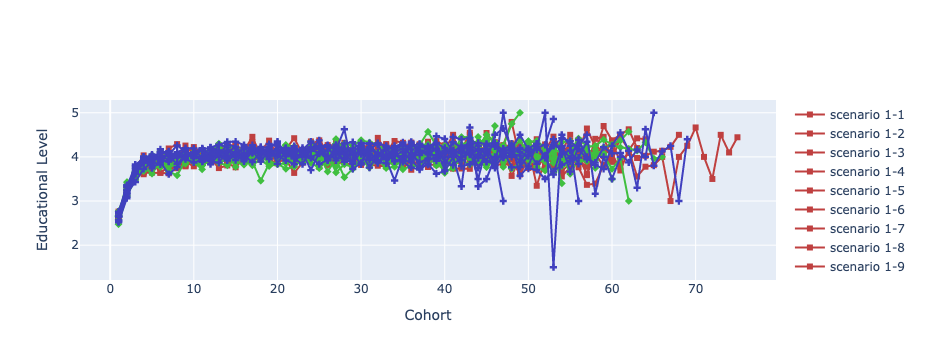

In [53]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        df_mean = df.groupby(['Cohort'], as_index=False).Edu_level.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Edu_level"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=int(scenario[-1]))))


fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()



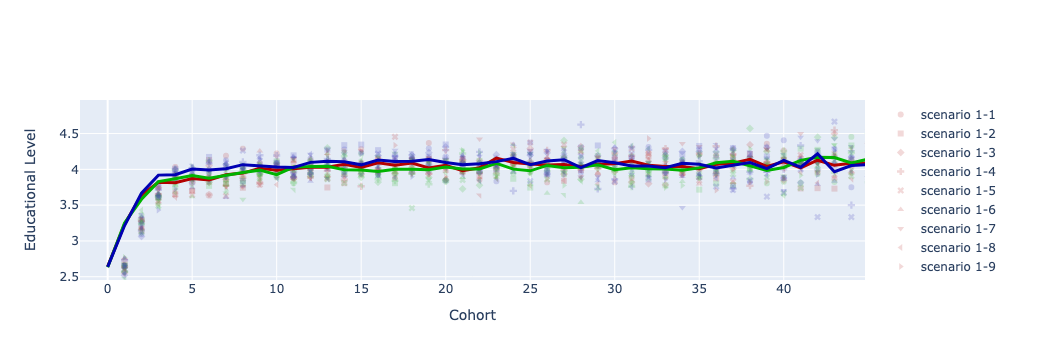

In [56]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        df_mean = df.groupby(['Cohort'], as_index=False).Edu_level.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Edu_level"],
                                  name=name,
                                  mode="markers",
                                  marker=dict(symbol=j, color=color, opacity=0.2)))


# To make the lines appear on top of the scatter, make a new loop
for i, scenario in enumerate(scenarios):
    dfs_scenario = df_dict[scenario]
    color2 = f"hsl({(i/len(scenarios))*360}, 100%, 35%)"
    # Calculate the average line for the current scenario
    max_length = max(len(df) for df in dfs_scenario)
    avg_line = pd.concat([df.loc[:max_length-1, "Edu_level"] for df in dfs_scenario], axis=1).mean(axis=1)
    avg_line = avg_line.reset_index(name="Edu_level").rename(columns={"index": "Cohort"})
    
    # Add the average line as a trace
    fig.add_trace(go.Scatter(
        x=avg_line["Cohort"], y=avg_line["Edu_level"],
        name=f"{scenario} (Avg)",
        mode="lines",
        line=dict(color=color2, width=3),
    ))

fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()


## Per Time Step (Raw Data)


In [258]:
rdfs[0].Step.max()

499

In [264]:
last_step = pd.DataFrame()
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        rdf = rdfs[row]
        last_step.loc[row, 'Scenario'] = j
        last_step.loc[row, 'Replication'] = i
        last_step.loc[row, 'last_step'] = rdf.Step.max()
        row += 1

In [265]:
last_step

Scenario  Replication  last_step
0        1.0          1.0      499.0
1        1.0          2.0      484.0
2        1.0          3.0      499.0
3        1.0          4.0      499.0
4        1.0          5.0      499.0
5        1.0          6.0      499.0
6        1.0          7.0      499.0
7        1.0          8.0      499.0
8        1.0          9.0      499.0
9        1.0         10.0      499.0
10       2.0          1.0      499.0
11       2.0          2.0      499.0
12       2.0          3.0      319.0
13       2.0          4.0      499.0
14       2.0          5.0      345.0
15       2.0          6.0      499.0
16       2.0          7.0      499.0
17       2.0          8.0      499.0
18       2.0          9.0      499.0
19       2.0         10.0      499.0
20       3.0          1.0      419.0
21       3.0          2.0      499.0
22       3.0          3.0      499.0
23       3.0          4.0      393.0
24       3.0          5.0      426.0
25       3.0          6.0      434.0
26       3.0          7.0      358.0
27       3.0          8.0      499.0
28       3.0          9.0      499.0
29       3.0         10.0      499.0

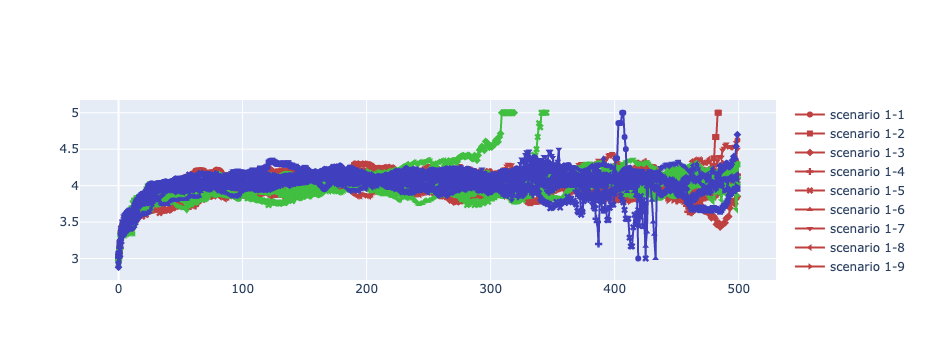

In [24]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        rdf = rdfs[row]
        df_mean = rdf.groupby(['Step'], as_index=False).Education.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, rdf in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=rdf["Step"], y=rdf["Education"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=j)))

# Show figure
fig.show()



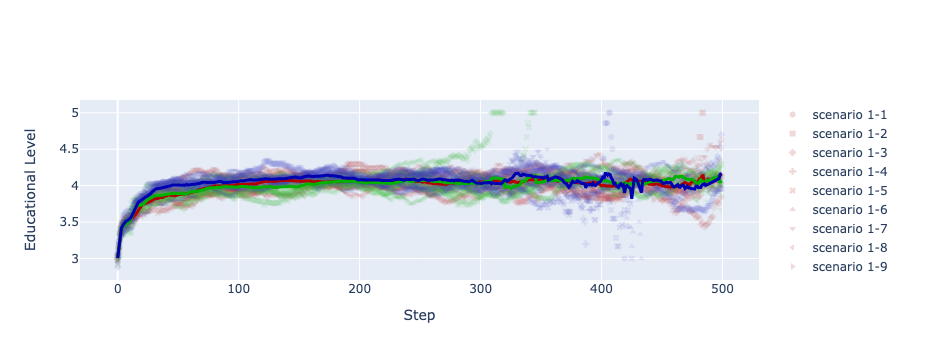

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Create dictionary of dataframes
df_dict = {}
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        rdf = rdfs[row]
        df_mean = rdf.groupby(['Step'], as_index=False).Education.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    
    # Loop through each replication of the current scenario
    for j, rdf in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        
        # Add scatter dots for each replication
        fig.add_trace(go.Scatter(
            x=rdf["Step"], y=rdf["Education"],
            name=name,
            mode="markers",
            marker=dict(symbol=j, color=color, opacity=0.1)
        ))


# To make the lines appear on top of the scatter, make a new loop
for i, scenario in enumerate(scenarios):
    dfs_scenario = df_dict[scenario]
    color2 = f"hsl({(i/len(scenarios))*360}, 100%, 35%)"
    # Calculate the average line for the current scenario
    max_length = max(len(df) for df in dfs_scenario)
    avg_line = pd.concat([df.loc[:max_length-1, "Education"] for df in dfs_scenario], axis=1).mean(axis=1)
    avg_line = avg_line.reset_index(name="Education").rename(columns={"index": "Step"})
    
    # Add the average line as a trace
    fig.add_trace(go.Scatter(
        x=avg_line["Step"], y=avg_line["Education"],
        name=f"{scenario} (Avg)",
        mode="lines",
        line=dict(color=color2, width=3),
    ))

fig.update_layout(
    xaxis_title="Step",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()


# Absolute Mobility

## Method 1

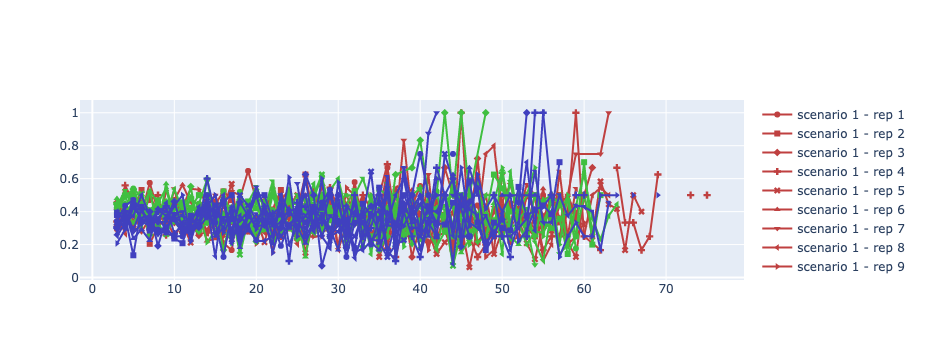

In [8]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        am1 = df[(df['Mother_Edu'] < 5) & (df['Father_Edu'] <5)]
        counts = am1[(am1['Edu_level'] > am1['Mother_Edu']) & (am1['Edu_level'] > am1['Father_Edu'])].groupby('Cohort').size()
        totals = am1.groupby(['Cohort']).size()
        probs = counts/totals
        if key in df_dict:
            df_dict[key].append({'Cohort': probs.index, 'Probability': probs.values})
        else:
            df_dict[key] = [{'Cohort': probs.index, 'Probability': probs.values}]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario} - rep {j+1}"
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Probability"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=int(j))))

# Show figure
fig.show()


In [57]:
absolute = pd.DataFrame(columns=["Scenario", "Replication", "Cohort", "Probability"])
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        df = dfs[row]
        am1 = df[(df['Mother_Edu'] < 5) & (df['Father_Edu'] <5)]
        am2 = df[(df['Mother_Edu'] == 5) | (df['Father_Edu'] ==5)]
        counts = am1[(am1['Edu_level'] > am1['Mother_Edu']) & (am1['Edu_level'] > am1['Father_Edu'])].groupby('Cohort').size()
        counts2 = am2[(am2['Edu_level'] == 5)].groupby('Cohort').size()
        totals = am1.groupby(['Cohort']).size()
        totals2 = am2.groupby('Cohort').size()
        probs = counts/totals
        probs2 = counts2 / totals2
        probs3 = probs2 + probs
        temp = pd.DataFrame({"Scenario": j, "Replication": i, "Cohort": probs.index, "Probability": probs.values})
        temp2 = pd.DataFrame({"Scenario": j, "Replication": i, "Cohort": probs3.index, "Probability": probs3.values})
        absolute = pd.concat([absolute, temp], ignore_index=True)
        absolute2 = pd.concat([absolute, temp2], ignore_index=True)
        row +=1

In [58]:
# absolute.drop('Replication')
abs1 = absolute.groupby(['Scenario', 'Cohort']).agg({'Probability': ["mean", "median", "var", "sem", "std"]}).reset_index()
abs1['ci95_hi'] = abs1['Probability']['mean'] + 1.96* abs1['Probability']['sem']
abs1['ci95_lo'] = abs1['Probability']['mean'] - 1.96* abs1['Probability']['sem']
# abs1.columns = abs1.columns.droplevel()
abs1.columns = ['_'.join(col) for col in abs1.columns]
abs1.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'ci95_hi_': 'ci95_hi', 'ci95_lo_':'ci95_lo'}, inplace = True)
abs1

Scenario  Cohort  Probability_mean  Probability_median  Probability_var  \
0           1       3          0.368278            0.372768         0.003509   
1           1       4          0.394438            0.373190         0.008489   
2           1       5          0.390056            0.390476         0.005815   
3           1       6          0.405786            0.398630         0.004566   
4           1       7          0.401345            0.385705         0.009663   
..        ...     ...               ...                 ...              ...   
197         3      64          0.500000            0.500000              NaN   
198         3      65               NaN                 NaN              NaN   
199         3      66          0.500000            0.500000              NaN   
200         3      67               NaN                 NaN              NaN   
201         3      69          0.500000            0.500000              NaN   

     Probability_sem  Probability_std   ci95_hi   ci95_lo  
0           0.018733         0.059239  0.404995  0.331562  
1           0.029136         0.092137  0.451545  0.337331  
2           0.024114         0.076255  0.437319  0.342792  
3           0.021367         0.067569  0.447666  0.363906  
4           0.031086         0.098303  0.462273  0.340416  
..               ...              ...       ...       ...  
197              NaN              NaN       NaN       NaN  
198              NaN              NaN       NaN       NaN  
199              NaN              NaN       NaN       NaN  
200              NaN              NaN       NaN       NaN  
201              NaN              NaN       NaN       NaN  

[202 rows x 9 columns]

In [60]:
'''
    To csv file for further analysis
'''

absolute.to_csv(csv_path/"absolute_measure1.csv")
absolute2.to_csv(csv_path/"absolute_measure2.csv")
abs1.to_csv(csv_path/"absolute_measure1_sum.csv")
abs2.to_csv(csv_path/"absolute_measure2_sum.csv")

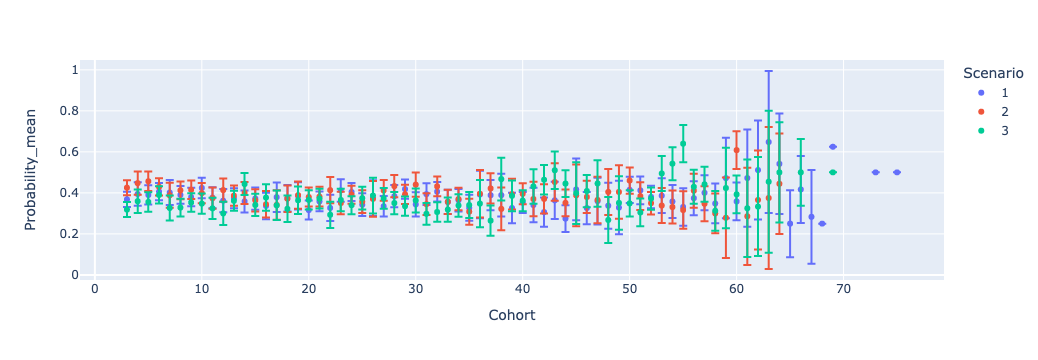

In [12]:
import plotly.express as px

abs1["Scenario"] = abs1["Scenario"].astype(str)
fig = px.scatter(abs1, x='Cohort', y='Probability_mean', color='Scenario').update_traces(  
                 error_y={'type': 'data', 
                          'symmetric': False, 
                          'array': abs1['ci95_hi']-abs1['Probability_mean'], 
                           'arrayminus':abs1['Probability_mean']-abs1['ci95_lo']}
                )

fig.show()

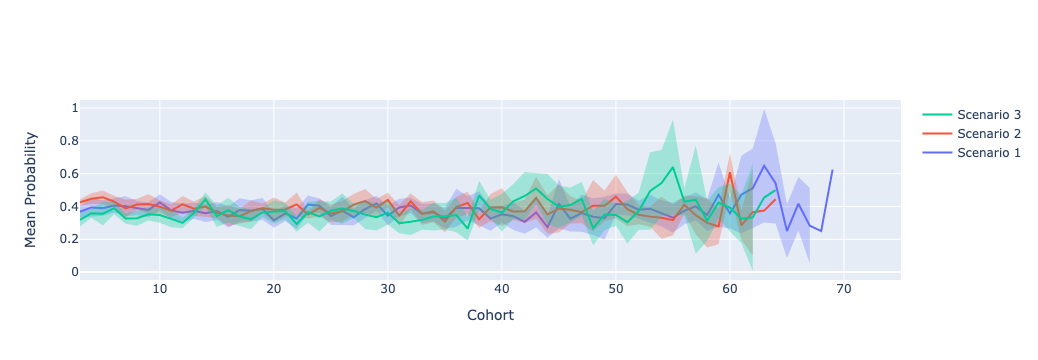

In [14]:
'''
    Continuous Graph
'''

import plotly.graph_objects as go

abs1["Scenario"] = abs1["Scenario"].astype(str)
scenarios = abs1["Scenario"].unique()

# Define a color map for the scenarios
color_map = {
    scenario: f"rgba({r}, {g}, {b}, 0.3)"
    for scenario, (r, g, b) in zip(scenarios, [(99, 109, 250), (239, 85, 59), (0, 204, 150)])
}




fig = go.Figure()

for scenario in scenarios:
    scenario_data = abs1[abs1["Scenario"] == scenario]
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['Probability_mean'],
                             name=f'Scenario {scenario}',
                             mode='lines',
                             line=dict(color=color_map[scenario].replace('0.3', '1')))
                 )
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_hi'],
                             name='Upper Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False))
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_lo'],
                             name='Lower Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False,
                             fillcolor=color_map[scenario],
                             fill='tonexty'))
fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Mean Probability",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

fig.show()

In [20]:
fig.write_image(project_path/"images/abs1_means2.png")
fig.write_html(project_path/"images/abs1_means.html") # with legend

## Method 2

In [59]:
# absolute.drop('Replication')
abs2 = absolute2.groupby(['Scenario', 'Cohort']).agg({'Probability': ["mean", "median", "var", "sem", "std"]}).reset_index()
abs2['ci95_hi'] = abs2['Probability']['mean'] + 1.96* abs2['Probability']['sem']
abs2['ci95_lo'] = abs2['Probability']['mean'] - 1.96* abs2['Probability']['sem']
abs2.columns = ['_'.join(col) for col in abs2.columns]
abs2.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'ci95_hi_': 'ci95_hi', 'ci95_lo_':'ci95_lo'}, inplace = True)
abs2

Scenario  Cohort  Probability_mean  Probability_median  Probability_var  \
0           1       3          0.368278            0.372768         0.003509   
1           1       4          0.394438            0.373190         0.008489   
2           1       5          0.390056            0.390476         0.005815   
3           1       6          0.405786            0.398630         0.004566   
4           1       7          0.401345            0.385705         0.009663   
..        ...     ...               ...                 ...              ...   
197         3      64          0.500000            0.500000              NaN   
198         3      65               NaN                 NaN              NaN   
199         3      66          0.500000            0.500000              NaN   
200         3      67               NaN                 NaN              NaN   
201         3      69          0.500000            0.500000              NaN   

     Probability_sem  Probability_std   ci95_hi   ci95_lo  
0           0.018733         0.059239  0.404995  0.331562  
1           0.029136         0.092137  0.451545  0.337331  
2           0.024114         0.076255  0.437319  0.342792  
3           0.021367         0.067569  0.447666  0.363906  
4           0.031086         0.098303  0.462273  0.340416  
..               ...              ...       ...       ...  
197              NaN              NaN       NaN       NaN  
198              NaN              NaN       NaN       NaN  
199              NaN              NaN       NaN       NaN  
200              NaN              NaN       NaN       NaN  
201              NaN              NaN       NaN       NaN  

[202 rows x 9 columns]

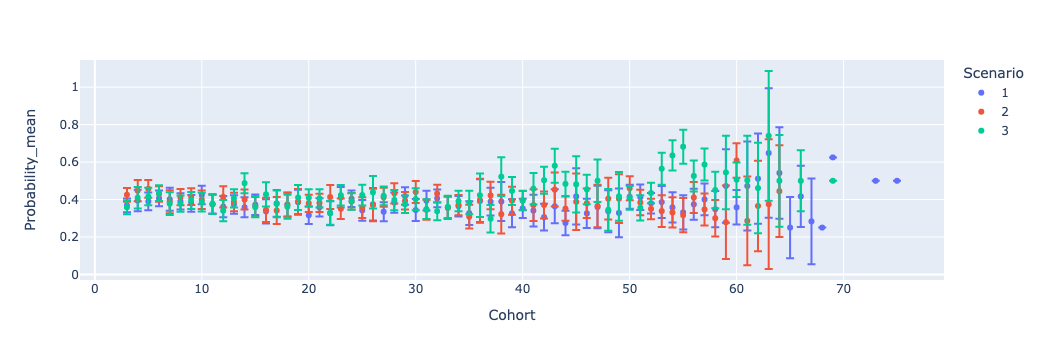

In [16]:
import plotly.express as px

abs2["Scenario"] = abs2["Scenario"].astype(str)
fig = px.scatter(abs2, x='Cohort', y='Probability_mean', color='Scenario').update_traces(  
                 error_y={'type': 'data', 
                          'symmetric': False, 
                          'array': abs2['ci95_hi']-abs2['Probability_mean'], 
                           'arrayminus':abs2['Probability_mean']-abs2['ci95_lo']}
                )

fig.show()

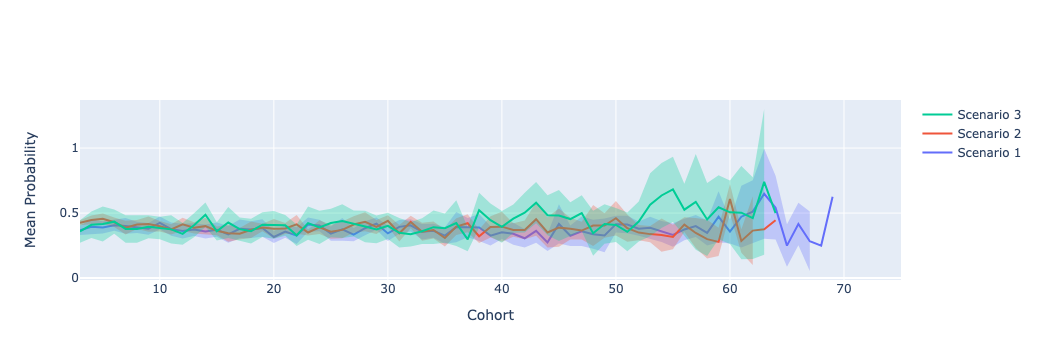

In [17]:
'''
    Continuous Graph
'''

import plotly.graph_objects as go

abs2["Scenario"] = abs2["Scenario"].astype(str)
scenarios = abs2["Scenario"].unique()

# Define a color map for the scenarios
color_map = {
    scenario: f"rgba({r}, {g}, {b}, 0.3)"
    for scenario, (r, g, b) in zip(scenarios, [(99, 109, 250), (239, 85, 59), (0, 204, 150)])
}




fig = go.Figure()

for scenario in scenarios:
    scenario_data = abs2[abs2["Scenario"] == scenario]
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['Probability_mean'],
                             name=f'Scenario {scenario}',
                             mode='lines',
                             line=dict(color=color_map[scenario].replace('0.3', '1')))
                 )
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_hi'],
                             name='Upper Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False))
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_lo'],
                             name='Lower Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False,
                             fillcolor=color_map[scenario],
                             fill='tonexty'))
fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Mean Probability",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

fig.show()

In [18]:
fig.write_image(project_path/"images/abs2_means.png")
fig.write_html(project_path/"images/abs2_means.html") # with legend

### All

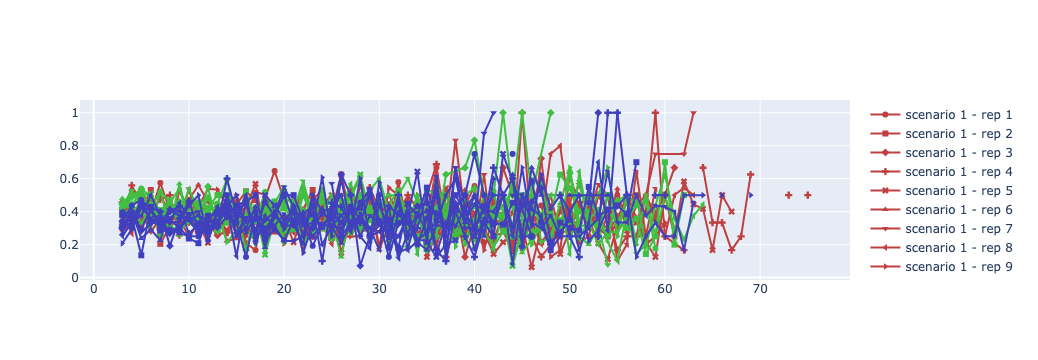

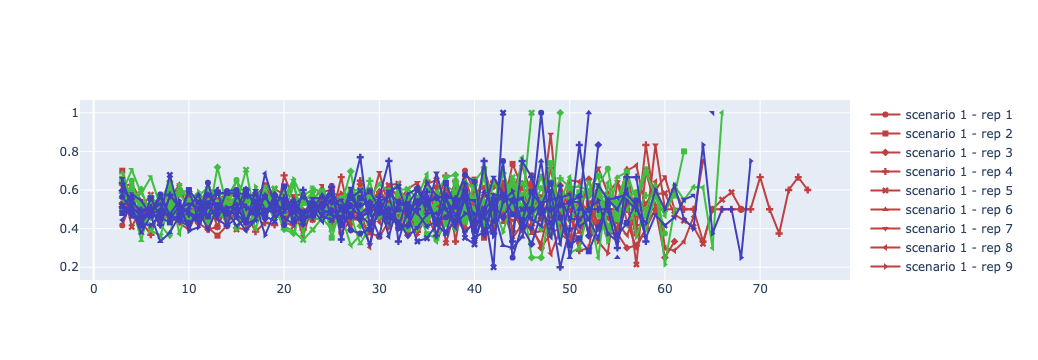

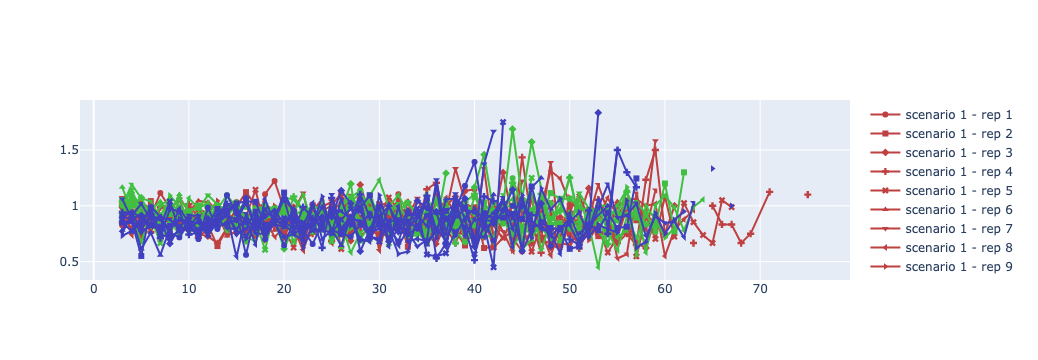

In [18]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        am1 = df[(df['Mother_Edu'] < 5) & (df['Father_Edu'] <5)]
        am2 = df[(df['Mother_Edu'] == 5) | (df['Father_Edu'] ==5)]
        counts = am1[(am1['Edu_level'] > am1['Mother_Edu']) & (am1['Edu_level'] > am1['Father_Edu'])].groupby('Cohort').size()
        counts2 = am2[(am2['Edu_level'] == 5)].groupby('Cohort').size()
        totals = am1.groupby(['Cohort']).size()
        totals2 = am2.groupby('Cohort').size()
        probs = counts/totals
        probs2 = counts2 / totals2
        probs3 = probs2 + probs
        if key in df_dict:
            df_dict[key].append({'Cohort': probs.index, 'Probability': probs.values, 'Cohort2': probs2.index, 'Probability2': probs2.values,
                                 'Probability3': probs3.values})
        else:
            df_dict[key] = [{'Cohort': probs.index, 'Probability': probs.values, 'Cohort2': probs2.index, 'Probability2': probs2.values,
                              'Probability3': probs3.values}]        
        row+=1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figures
fig = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario} - rep {j+1}"
        # Add traces to figures
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Probability"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=int(j))))
        fig2.add_trace(go.Scatter(x=df["Cohort2"], y=df["Probability2"],
                                   name=name,
                                   mode="lines+markers",
                                   line=dict(color=color),
                                   marker=dict(symbol=int(j))))
        fig3.add_trace(go.Scatter(x=df["Cohort"], y=df["Probability3"],
                                   name=name,
                                   mode="lines+markers",
                                   line=dict(color=color),
                                   marker=dict(symbol=int(j))))

# Show figures
fig.show()
fig2.show()
fig3.show()


# Relative Mobility
* See R Script

# Who Benefits?

In [19]:
dfs[0].columns

Index(['AgentID', 'Step', 'Age', 'Edu_level', 'Gender', 'Income', 'Generation',
       'Cohort', 'Weight', 'Capital', 'Brut', 'Child1', 'Child2', 'Mother',
       'Father', 'Partner', 'Education', 'Cultural', 'Economic', 'Social',
       'Child1_Edu', 'Child2_Edu', 'Child1_Income', 'Child2_Income',
       'Mother_Edu', 'Father_Edu', 'Mother_Income', 'Father_Income',
       'Mother_Cultural', 'Mother_Economic', 'Mother_Social',
       'Father_Cultural', 'Father_Economic', 'Father_Social', 'Scenario',
       'Replication'],
      dtype='object')

In [63]:
'''
    Make a function to create summary tables for each data set
'''
def summary_tab(df):
    ls = pd.DataFrame()
    row = 0
    for i in df.Cohort.unique():
        cht = df[df['Cohort'] == i]
        for j in range(1, 6):
            for k in range(1, 6):
                new = cht[(cht['Mother_Edu'] == j) | (cht['Father_Edu'] == k)]
                n = new.size
                avg = new['Edu_level'].mean()
                med = new['Edu_level'].median()
                ls.loc[row, 'Cohort'] = i
                ls.loc[row, 'Average Edu'] = avg
                ls.loc[row, 'Median Edu'] = med
                ls.loc[row, 'Total'] = n
                ls.loc[row, 'Mother Edu'] = j
                ls.loc[row, 'Father Edu'] = k
                row += 1
    return ls


In [64]:
ls_full = pd.DataFrame()
row = 0
for i in range(1, num_scen+1):
    for j in range(1,num_reps+1):
        df = dfs[row]
        df2 =  df[df['Generation'] != 1]
        df3 = summary_tab(df2)
        df3['Scenario'] = i
        df3['Replication'] = j
        ls_full = pd.concat([ls_full, df3], ignore_index=True)
        row +=1

In [65]:
# pd.set_option('display.max_rows', None)
ls_full

Cohort  Average Edu  Median Edu   Total  Mother Edu  Father Edu  \
0         7.0     3.888889         4.5   648.0         1.0         1.0   
1         7.0     3.954545         4.0   792.0         1.0         2.0   
2         7.0     3.950000         4.0  1440.0         1.0         3.0   
3         7.0     4.137255         4.0  1836.0         1.0         4.0   
4         7.0     4.343750         5.0  2304.0         1.0         5.0   
...       ...          ...         ...     ...         ...         ...   
42270    65.0     5.000000         5.0    36.0         5.0         1.0   
42271    65.0     5.000000         5.0    36.0         5.0         2.0   
42272    65.0     5.000000         5.0    36.0         5.0         3.0   
42273    65.0     5.000000         5.0    36.0         5.0         4.0   
42274    65.0     5.000000         5.0    36.0         5.0         5.0   

       Scenario  Replication  
0             1            1  
1             1            1  
2             1            1  
3             1            1  
4             1            1  
...         ...          ...  
42270         3           10  
42271         3           10  
42272         3           10  
42273         3           10  
42274         3           10  

[42275 rows x 8 columns]

In [157]:
# pd.set_option("display.max_rows", 25)

In [66]:
agg_ls = ls_full.groupby(['Scenario', 'Cohort', 'Mother Edu', 'Father Edu']).agg({'Average Edu': ["mean", "sem", "std"], 'Median Edu': ['mean', 'sem', 'std'] }).reset_index()
agg_ls['ci95_hi_avg'] = agg_ls['Average Edu']['mean'] + 1.96* agg_ls['Average Edu']['sem']
agg_ls['ci95_lo_avg'] = agg_ls['Average Edu']['mean'] - 1.96* agg_ls['Average Edu']['sem']
agg_ls['ci95_hi_med'] = agg_ls['Median Edu']['mean'] + 1.96* agg_ls['Median Edu']['sem']
agg_ls['ci95_lo_med'] = agg_ls['Median Edu']['mean'] - 1.96* agg_ls['Median Edu']['sem']
agg_ls.columns = ['_'.join(col) for col in agg_ls.columns]
agg_ls.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'Mother Edu_':'Mother Edu', 'Father Edu_':'Father Edu',
                         'ci95_hi_avg_': 'ci95_hi_avg', 'ci95_lo_avg_':'ci95_lo_avg',
                         'ci95_hi_med_': 'ci95_hi_med', 'ci95_lo_med_':'ci95_lo_med'}, inplace = True)

agg_ls['Parent Edu'] = agg_ls.apply(lambda x: [x['Mother Edu'], x['Father Edu']], axis=1)

agg_ls.head(5)

Scenario  Cohort  Mother Edu  Father Edu  Average Edu_mean  \
0         1     3.0         1.0         1.0          1.805588   
1         1     3.0         1.0         2.0          2.405332   
2         1     3.0         1.0         3.0          3.160301   
3         1     3.0         1.0         4.0          3.436475   
4         1     3.0         1.0         5.0          3.553121   

   Average Edu_sem  Average Edu_std  Median Edu_mean  Median Edu_sem  \
0         0.125877         0.398057              1.2        0.133333   
1         0.089751         0.283817              2.0        0.149071   
2         0.073470         0.232331              3.3        0.152753   
3         0.068618         0.216990              4.0        0.000000   
4         0.076782         0.242806              4.1        0.100000   

   Median Edu_std  ci95_hi_avg  ci95_lo_avg  ci95_hi_med  ci95_lo_med  \
0        0.421637     2.052307     1.558870     1.461333     0.938667   
1        0.471405     2.581244     2.229421     2.292180     1.707820   
2        0.483046     3.304301     3.016300     3.599395     3.000605   
3        0.000000     3.570967     3.301983     4.000000     4.000000   
4        0.316228     3.703614     3.402628     4.296000     3.904000   

   Parent Edu  
0  [1.0, 1.0]  
1  [1.0, 2.0]  
2  [1.0, 3.0]  
3  [1.0, 4.0]  
4  [1.0, 5.0]

## Plot

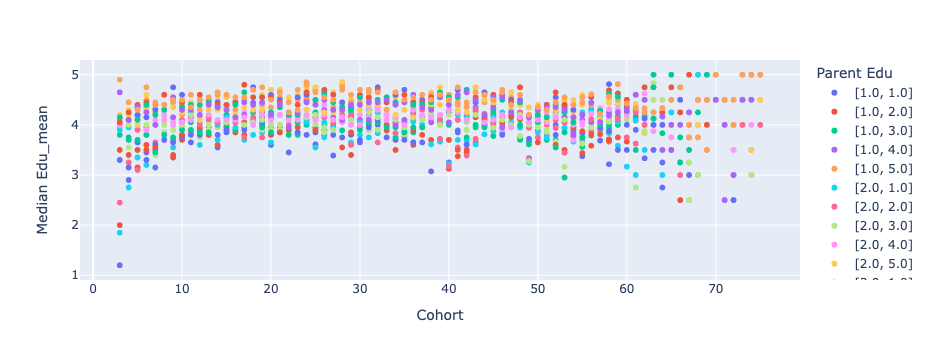

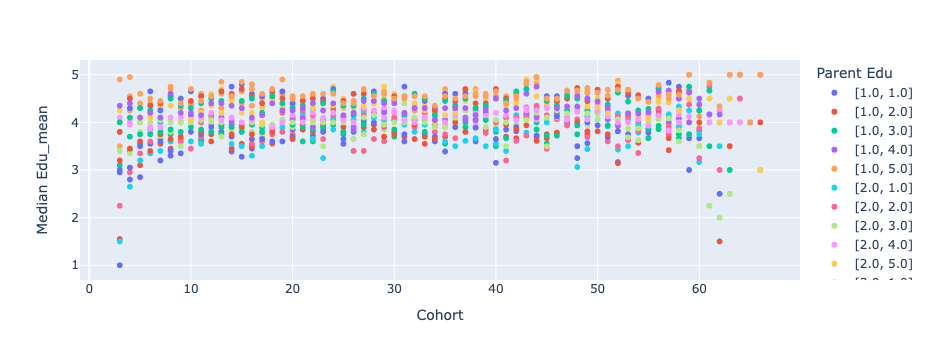

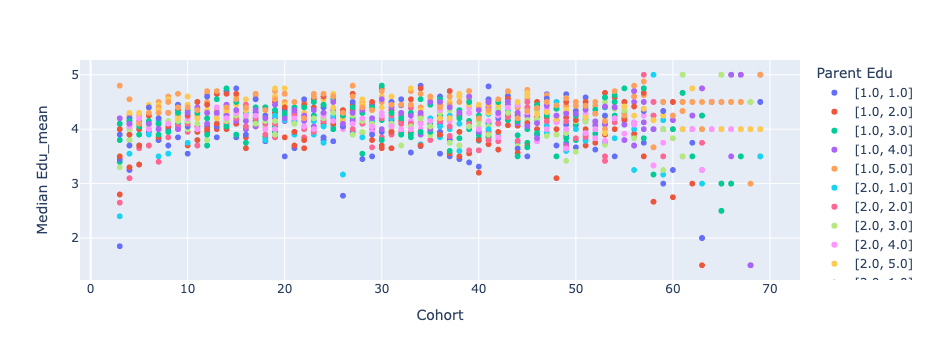

In [67]:
import plotly.express as px

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

fig1.show()
fig2.show()
fig3.show()

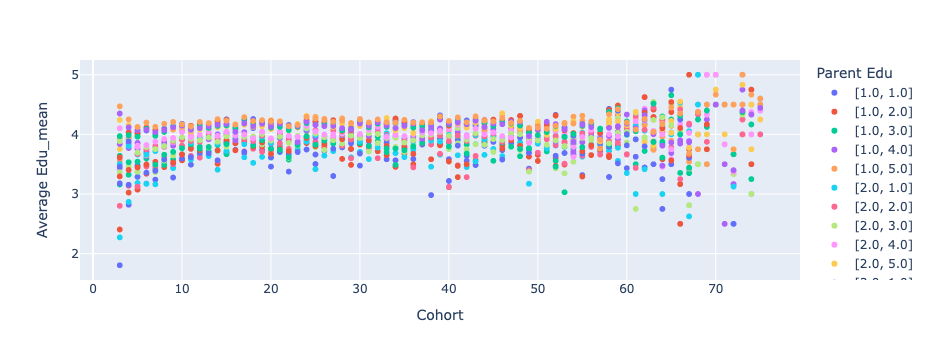

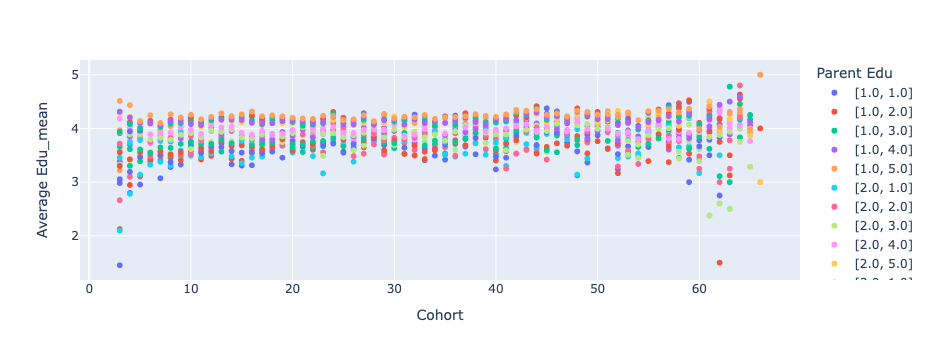

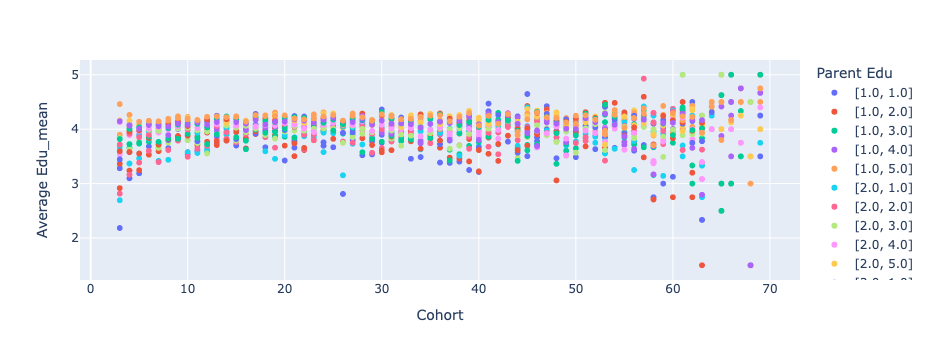

In [231]:
import plotly.express as px

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

fig1.show()
fig2.show()
fig3.show()

More mixing in scenario 3 compared to 1 and 2. 

In [69]:
agg_ls['Parent Edu 2'] = agg_ls['Parent Edu'].apply(lambda x: '[1, 2]' if x == '[1.0, 2.0]' or x == '[2.0, 1.0]'
                                                    else '[1, 3]' if x == '[1.0, 3.0]' or x == '[3.0, 1.0]'
                                                    else '[1, 4]' if x == '[1.0, 4.0]' or x == '[4.0, 1.0]' 
                                                    else '[1, 5]' if x == '[1.0, 5.0]' or x == '[5.0, 1.0]' 
                                                    else '[2, 3]' if x == '[2.0, 3.0]' or x == '[3.0, 2.0]' 
                                                    else '[2, 4]' if x == '[2.0, 4.0]' or x == '[4.0, 2.0]' 
                                                    else '[2, 5]' if x == '[2.0, 5.0]' or x == '[5.0, 2.0]'
                                                    else '[3, 4]' if x == '[3.0, 4.0]' or x == '[4.0, 3.0]'
                                                    else '[3, 5]' if x == '[3.0, 5.0]' or x == '[5.0, 3.0]' 
                                                    else '[4, 5]' if x == '[4.0, 5.0]' or x == '[5.0, 4.0]' 
                                                    else '[1, 1]' if x == '[1.0, 1.0]'
                                                    else '[2, 2]' if x == '[2.0, 2.0]'
                                                    else '[3, 3]' if x == '[3.0, 3.0]'
                                                    else '[4, 4]' if x == '[4.0, 4.0]'
                                                    else '[5, 5]' if x == '[5.0, 5.0]' 
                                                   else x)

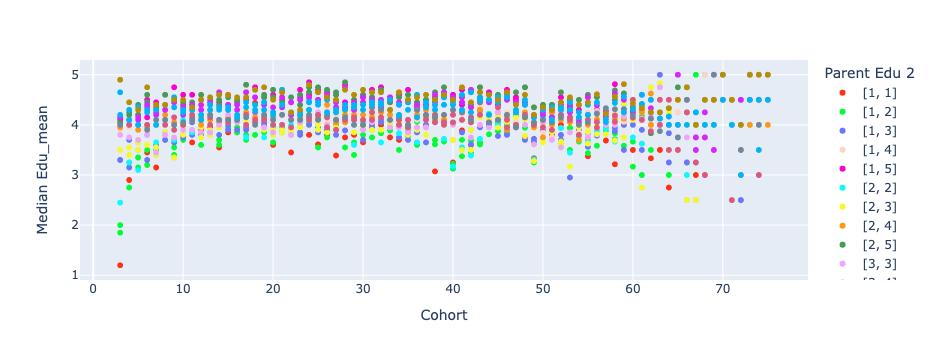

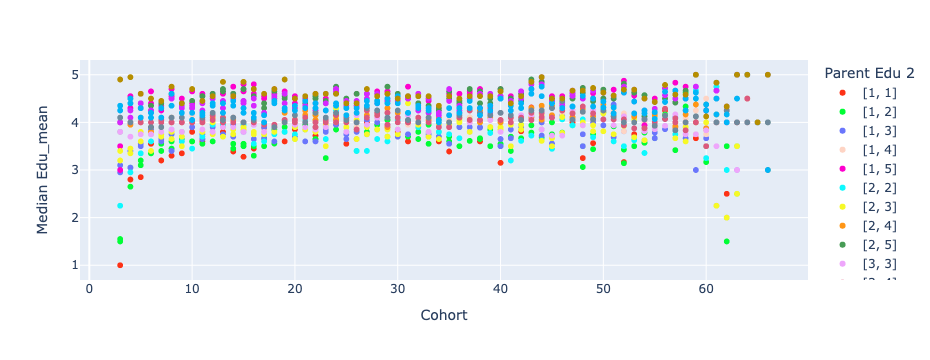

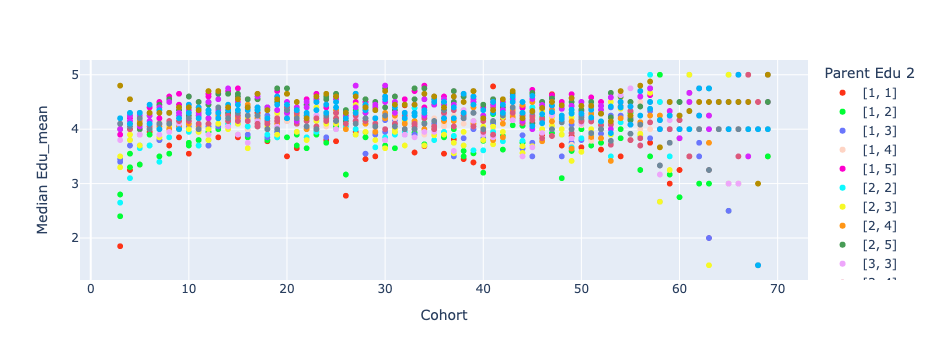

In [70]:
import plotly.express as px

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

fig1.show()
fig2.show()
fig3.show()

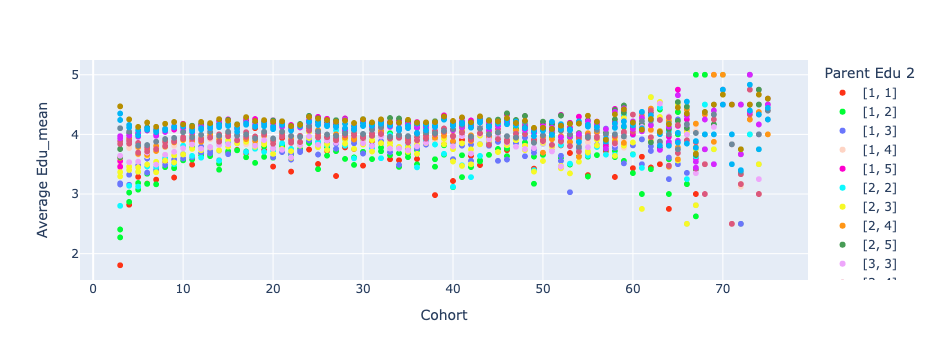

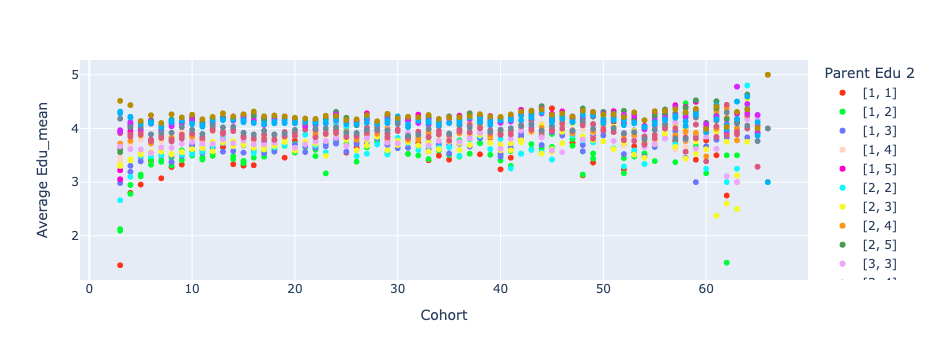

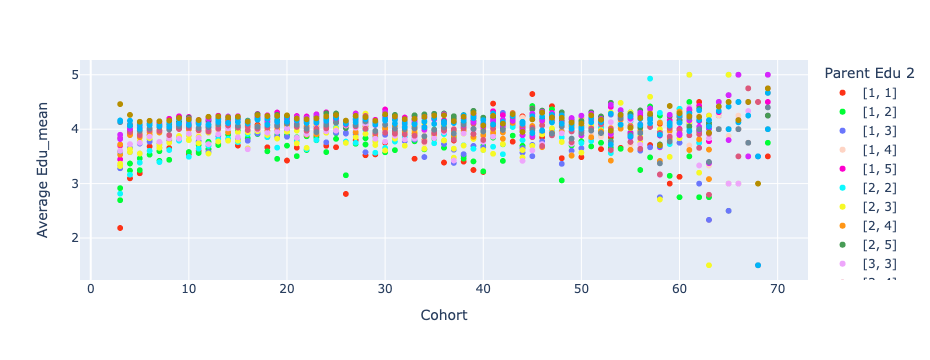

In [230]:
import plotly.express as px

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

fig1.show()
fig2.show()
fig3.show()

## Variance Differences?

In [232]:
var = agg_ls.groupby(['Scenario', 'Cohort']).agg({'Median Edu_mean': ["mean", "std"], 'Average Edu_mean': ["mean", "std"]}).reset_index()
var.columns = ['_'.join(col) for col in var.columns]
var.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'Median Edu_mean_mean': 'Med_Mean', 'Median Edu_mean_std': 'Med_Std', 'Average Edu_mean_mean': 'Avg_Mean', 'Average Edu_mean_std': 'Avg_Std'}, inplace = True)
var

Scenario  Cohort  Med_Mean   Med_Std  Avg_Mean   Avg_Std
0           1     3.0  3.646000  0.880805  3.490934  0.636527
1           1     4.0  3.818000  0.454808  3.689232  0.421734
2           1     5.0  3.870000  0.372212  3.693628  0.324290
3           1     6.0  3.994000  0.399301  3.756913  0.313698
4           1     7.0  3.920000  0.379693  3.732800  0.302737
..        ...     ...       ...       ...       ...       ...
199         3    65.0  3.931818  0.820793  3.930303  0.832216
200         3    66.0  4.227273  0.631085  4.115530  0.583324
201         3    67.0  4.250000  0.516398  4.145833  0.484481
202         3    68.0  2.710526  1.346970  2.578947  1.227726
203         3    69.0  4.521739  0.532538  4.394203  0.438938

[204 rows x 6 columns]

In [233]:
s1 = var[(var['Scenario'] == 1) & (var['Cohort'] < 50)]
s2 = var[(var['Scenario'] == 2) & (var['Cohort'] < 50)]
s3 = var[(var['Scenario'] == 3) & (var['Cohort'] < 50)]

In [252]:
print(s3.Med_Std.values-s2.Med_Std.values)
print(s3.Med_Std.values-s1.Med_Std.values)
print(s2.Med_Std.values-s1.Med_Std.values)

[-0.3076689  -0.2684566  -0.19659543 -0.16054117 -0.04953982 -0.18434338
 -0.14512589 -0.04550704 -0.09582101 -0.01048435 -0.11357639 -0.189843
 -0.14875835 -0.16533132 -0.11169519 -0.1507812  -0.03841684 -0.03063962
 -0.03330194 -0.08556404 -0.09500767 -0.04477478 -0.03875858  0.02978623
 -0.0723061   0.02692499 -0.08013223  0.05872776 -0.05267146 -0.05519698
 -0.02595229  0.10427885 -0.10739506  0.01405885  0.07052315  0.05789833
  0.08667103 -0.12353525 -0.08018009 -0.06390017 -0.17193999 -0.16512525
 -0.02655641  0.01047145 -0.00859743 -0.13938087  0.00540867]
[-0.22165738 -0.11132063 -0.10179551 -0.20895092 -0.1092457  -0.04156686
 -0.23024139  0.00396019 -0.00268403  0.01967538 -0.04929381 -0.10607318
  0.03933154  0.04608291 -0.14823063 -0.07767611  0.01630065 -0.06069624
 -0.07536208 -0.01822171  0.00826033 -0.03827028 -0.08620079  0.05629908
 -0.02318519 -0.02233687 -0.04534178  0.03953974 -0.02604862 -0.06854294
  0.05820344 -0.00318319 -0.03940767 -0.03572787  0.11661576  0.

In [253]:
print(s3.Avg_Std.values-s2.Avg_Std.values)
print(s3.Avg_Std.values-s1.Avg_Std.values)
print(s2.Avg_Std.values-s1.Avg_Std.values)

[-2.34483381e-01 -1.42626222e-01 -6.59710181e-02 -1.18617295e-01
 -4.53999506e-02 -1.12200502e-01 -1.22635359e-01 -1.13440120e-02
 -3.91110825e-02 -3.14806059e-02 -4.83818110e-02 -1.39861015e-01
 -1.19527848e-01 -1.16295441e-01 -1.10600321e-01 -4.96110454e-02
 -8.41101937e-03 -3.22967525e-02  1.09866943e-03 -2.97388456e-02
 -1.16854679e-01 -9.62448166e-03 -5.17809714e-02  1.00769565e-01
 -5.11572189e-02  7.46434785e-02 -5.20269712e-02  2.06773864e-02
 -3.19976403e-02 -7.61720943e-02 -8.18144822e-02  1.64616915e-02
 -9.10936728e-02 -1.26123247e-02  2.93940200e-02  7.02281927e-02
  7.96662544e-02 -2.32514451e-02 -8.91650856e-02 -2.33194417e-02
 -9.04030321e-02 -5.64181927e-02  1.45713564e-02  4.38732133e-02
 -1.23154053e-04 -4.66419434e-02 -5.06926422e-02]
[-0.1333532  -0.0984821  -0.05403865 -0.14524223 -0.0799447  -0.03741794
 -0.12563311  0.0200728   0.00503713  0.01327563 -0.02555202 -0.13200586
 -0.01499285  0.04116241 -0.08897689 -0.00944329  0.01443625 -0.0409269
  0.02061694 -0.0

# A More Detailed Assessment on Who Benefits

In [180]:
'''
    Make a function to create summary tables for each data set
'''
def simple_tab(df):
    ls = pd.DataFrame()
    row = 0
    for i in df.Cohort.unique():
        cht = df[df['Cohort'] == i]
        for j in range(1, 6):
            for k in range(1, 6):
                ls.loc[row, 'Cohort'] = i
                ls.loc[row, 'Mother Edu'] = j
                ls.loc[row, 'Father Edu'] = k
                row += 1
    return ls

In [181]:
ls_full2 = pd.DataFrame()
row = 0
for i in range(1, num_scen+1):
    for j in range(1,num_reps+1):
        df = dfs[row]
        df2 =  df[df['Generation'] != 1]
        df3 = simple_tab(df2)
        df3['Scenario'] = i
        df3['Replication'] = j
        df3['Edu_level'] = df['Edu_level']
        ls_full2 = pd.concat([ls_full2, df3], ignore_index=True)
        row +=1

In [183]:
ls_full2

Cohort  Mother Edu  Father Edu  Scenario  Replication  Edu_level
0         7.0         1.0         1.0         1            1          4
1         7.0         1.0         2.0         1            1          2
2         7.0         1.0         3.0         1            1          3
3         7.0         1.0         4.0         1            1          3
4         7.0         1.0         5.0         1            1          4
...       ...         ...         ...       ...          ...        ...
42270    65.0         5.0         1.0         3           10          1
42271    65.0         5.0         2.0         3           10          5
42272    65.0         5.0         3.0         3           10          5
42273    65.0         5.0         4.0         3           10          5
42274    65.0         5.0         5.0         3           10          4

[42275 rows x 6 columns]

In [184]:
ls_full2['Parent Edu'] = ls_full2.apply(lambda x: [x['Mother Edu'], x['Father Edu']], axis=1)
ls_full2['Parent Edu'] = ls_full2['Parent Edu'].astype(str)
ls_full2['Parent Edu 2'] = ls_full2['Parent Edu'].apply(lambda x: '[1, 2]' if x == '[1.0, 2.0]' or x == '[2.0, 1.0]'
                                                    else '[1, 3]' if x == '[1.0, 3.0]' or x == '[3.0, 1.0]'
                                                    else '[1, 4]' if x == '[1.0, 4.0]' or x == '[4.0, 1.0]' 
                                                    else '[1, 5]' if x == '[1.0, 5.0]' or x == '[5.0, 1.0]' 
                                                    else '[2, 3]' if x == '[2.0, 3.0]' or x == '[3.0, 2.0]' 
                                                    else '[2, 4]' if x == '[2.0, 4.0]' or x == '[4.0, 2.0]' 
                                                    else '[2, 5]' if x == '[2.0, 5.0]' or x == '[5.0, 2.0]'
                                                    else '[3, 4]' if x == '[3.0, 4.0]' or x == '[4.0, 3.0]'
                                                    else '[3, 5]' if x == '[3.0, 5.0]' or x == '[5.0, 3.0]' 
                                                    else '[4, 5]' if x == '[4.0, 5.0]' or x == '[5.0, 4.0]' 
                                                    else '[1, 1]' if x == '[1.0, 1.0]'
                                                    else '[2, 2]' if x == '[2.0, 2.0]'
                                                    else '[3, 3]' if x == '[3.0, 3.0]'
                                                    else '[4, 4]' if x == '[4.0, 4.0]'
                                                    else '[5, 5]' if x == '[5.0, 5.0]' 
                                                   else x)
ls_full2

Cohort  Mother Edu  Father Edu  Scenario  Replication  Edu_level  \
0         7.0         1.0         1.0         1            1          4   
1         7.0         1.0         2.0         1            1          2   
2         7.0         1.0         3.0         1            1          3   
3         7.0         1.0         4.0         1            1          3   
4         7.0         1.0         5.0         1            1          4   
...       ...         ...         ...       ...          ...        ...   
42270    65.0         5.0         1.0         3           10          1   
42271    65.0         5.0         2.0         3           10          5   
42272    65.0         5.0         3.0         3           10          5   
42273    65.0         5.0         4.0         3           10          5   
42274    65.0         5.0         5.0         3           10          4   

       Parent Edu Parent Edu 2  
0      [1.0, 1.0]       [1, 1]  
1      [1.0, 2.0]       [1, 2]  
2      [1.0, 3.0]       [1, 3]  
3      [1.0, 4.0]       [1, 4]  
4      [1.0, 5.0]       [1, 5]  
...           ...          ...  
42270  [5.0, 1.0]       [1, 5]  
42271  [5.0, 2.0]       [2, 5]  
42272  [5.0, 3.0]       [3, 5]  
42273  [5.0, 4.0]       [4, 5]  
42274  [5.0, 5.0]       [5, 5]  

[42275 rows x 8 columns]

In [195]:
ls_full3 = ls_full2.groupby(['Scenario', 'Cohort', 'Edu_level', 'Parent Edu 2'])['Parent Edu 2'].size().reset_index(name='Size')
ls_full3

Scenario  Cohort  Edu_level Parent Edu 2  Size
0             1     3.0          1       [1, 1]     1
1             1     3.0          1       [1, 2]     2
2             1     3.0          1       [1, 3]     1
3             1     3.0          1       [1, 5]     3
4             1     3.0          1       [2, 3]     3
...         ...     ...        ...          ...   ...
11786         3    69.0          5       [2, 4]     1
11787         3    69.0          5       [2, 5]     1
11788         3    69.0          5       [3, 3]     1
11789         3    69.0          5       [3, 4]     1
11790         3    69.0          5       [4, 5]     1

[11791 rows x 5 columns]

In [208]:
add = ls_full2.groupby(['Scenario', 'Cohort', 'Parent Edu 2'])['Parent Edu 2'].size().reset_index(name='Total')

ls_full4 = pd.merge(ls_full3, add)
ls_full4['Perc'] = ls_full4['Size']/ls_full4['Total']
ls_full4

Scenario  Cohort Edu_level Parent Edu 2  Size  Total  Perc
0             1     3.0         1       [1, 1]     1     10   0.1
1             1     3.0         2       [1, 1]     2     10   0.2
2             1     3.0         3       [1, 1]     1     10   0.1
3             1     3.0         4       [1, 1]     2     10   0.2
4             1     3.0         5       [1, 1]     4     10   0.4
...         ...     ...       ...          ...   ...    ...   ...
11786         3    69.0         5       [2, 4]     1      2   0.5
11787         3    69.0         4       [3, 4]     1      2   0.5
11788         3    69.0         5       [3, 4]     1      2   0.5
11789         3    69.0         4       [3, 5]     2      2   1.0
11790         3    69.0         5       [3, 3]     1      1   1.0

[11791 rows x 7 columns]

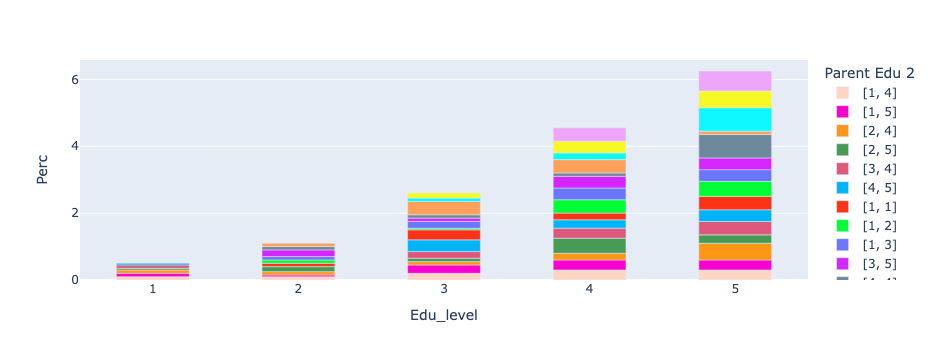

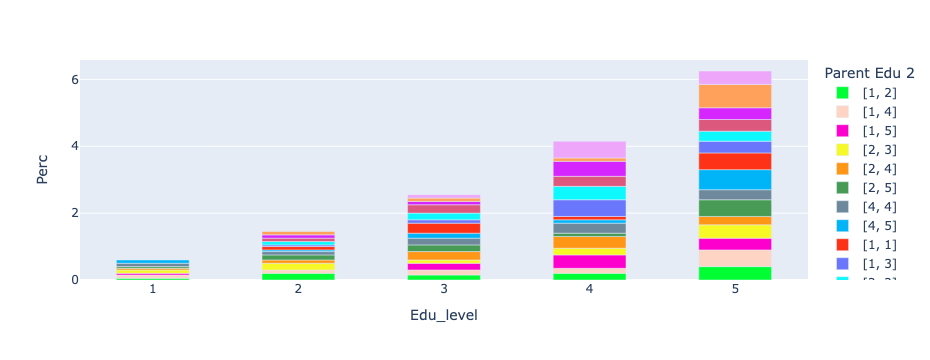

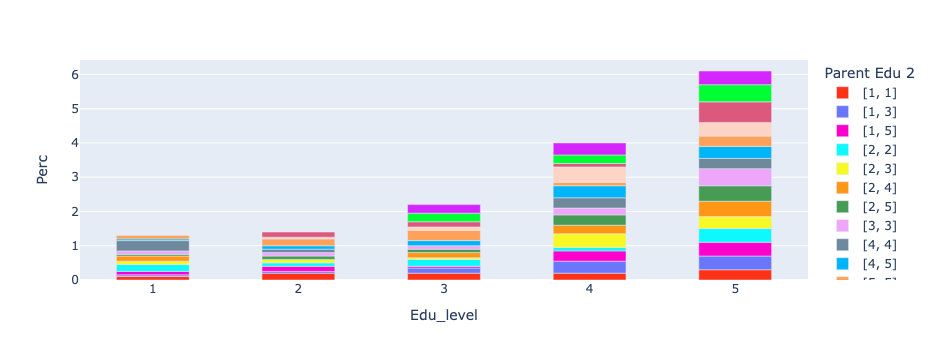

In [228]:
import plotly.express as px
colormap = {'[1, 1]': px.colors.qualitative.Light24[0], '[1, 2]': px.colors.qualitative.Light24[1],
            '[1, 3]': px.colors.qualitative.Light24[2], '[1, 4]': px.colors.qualitative.Light24[3],
            '[1, 5]': px.colors.qualitative.Light24[4], '[2, 2]': px.colors.qualitative.Light24[5],
            '[2, 3]': px.colors.qualitative.Light24[6], '[2, 4]': px.colors.qualitative.Light24[7],
            '[2, 5]': px.colors.qualitative.Light24[8], '[3, 3]': px.colors.qualitative.Light24[9],
            '[3, 4]': px.colors.qualitative.Light24[10], '[3, 5]': px.colors.qualitative.Light24[11],
            '[4, 4]': px.colors.qualitative.Light24[12], '[4, 5]': px.colors.qualitative.Light24[13]
           }

ls_full4["Parent Edu 2"] = ls_full4["Parent Edu 2"].astype(str)
ls_full4["Edu_level"] = ls_full4["Edu_level"].astype(str)

scenarios = [1, 2, 3]
cohort = 4 # Change the cohort
figs = []

for scenario in scenarios:
    data = ls_full4[(ls_full4['Scenario'] == scenario) & (ls_full4['Cohort'] == 4)]
    fig = px.bar(data, x='Edu_level', y='Perc', color='Parent Edu 2', color_discrete_map=colormap)
    fig.update_traces(width=0.5)
    figs.append(fig)

for fig in figs:
    fig.show()

# End